# Assisted Fine Clustering

Spin off of `FineClustering.ipynb`. Idea is to pre-segregate peaks based on state in fibroblast and iPSC. Then perform k-means within each of the 4 sets.

In [2]:
library(reshape2)
library(viridis)
library(scales)
library(ggplot2)
library(ggrepel)
library(DESeq2)
library(ClusterR)
library(RColorBrewer)
library(patchwork)
library(cowplot)
library(Matrix)
library(ggdendro)

In [3]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [4]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

In [5]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20210717_n62599/pmat.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  62599 530910

In [6]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
dim(metaData)
head(metaData, 5)

[1] 62599     5

barcode          sample umap1      umap2     cluster
D0_AAACACGCTAGTACGG AAACACGCTAGTACGG D0     -1.8037916 -9.507773 1      
D0_AAACACGCTCTTCAAG AAACACGCTCTTCAAG D0      0.7074551 -9.406457 1      
D0_AAACACGCTGATCCAT AAACACGCTGATCCAT D0     -2.9559933 -7.641148 1      
D0_AAACCCTGACCGCTAG AAACCCTGACCGCTAG D0     -3.6119107 -8.443144 1      
D0_AAACCCTGATTGCAGT AAACCCTGATTGCAGT D0      0.5002119 -8.759449 3

In [7]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 530910      4

chr   bp1      bp2      site_name              
chr17_32960817_32961317 chr17 32960817 32961317 chr17_32960817_32961317
chr17_75764252_75764752 chr17 75764252 75764752 chr17_75764252_75764752
chr17_1473114_1473614   chr17  1473114  1473614 chr17_1473114_1473614  
chr17_4206897_4207397   chr17  4206897  4207397 chr17_4206897_4207397  
chr17_423409_423909     chr17   423409   423909 chr17_423409_423909    
chr17_1964634_1965134   chr17  1964634  1965134 chr17_1964634_1965134

In [8]:
tmp = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))

In [9]:
# check if reads at OCT promoter (none in initial version)
sum(pmat[,subjectHits(findOverlaps(GRanges(c("chr6:31170549-31170836"))+500, tmp))])

[1] 1768

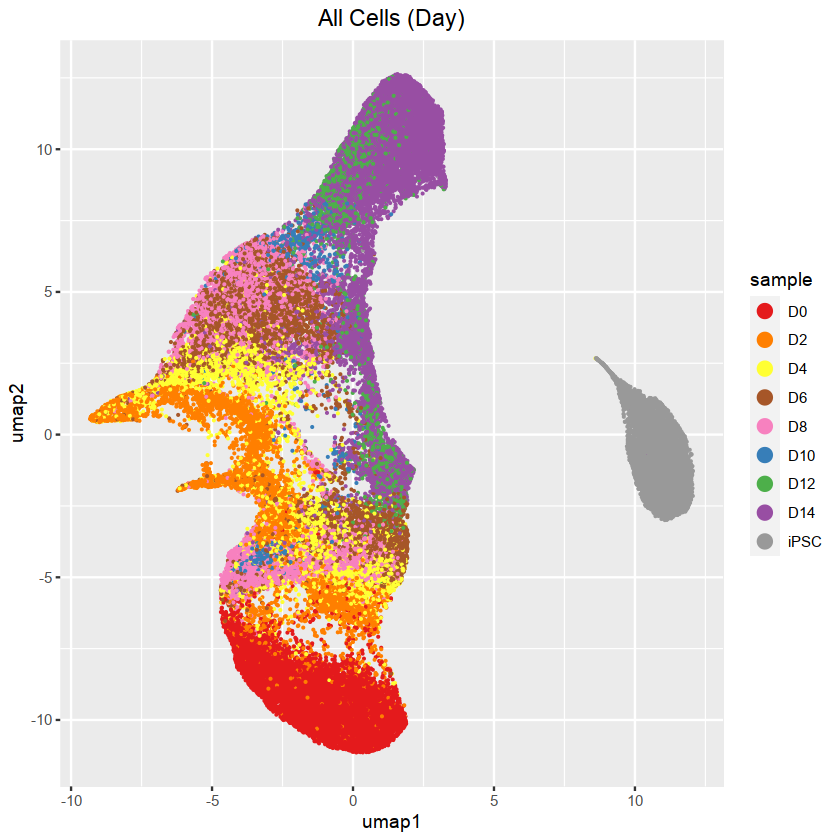

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                sample=metaData$sample)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.1, alpha=1, aes(x=umap1 , y=umap2, col=sample)) +
scale_color_brewer(breaks=DAYS, palette = "Set1") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5)) + 
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

## Finer Clustering

In [12]:
library(RANN)
library(leiden)

In [ ]:
# feats = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/features.10d.tsv", header = T)
# rownames(feats) = feats$sample_barcode
# feats$sample_barcode = NULL
# head(feats,3)

In [ ]:
# K = 15

# nn.ranked <- nn2(
#         data = feats,
#         k = K,
#         searchtype = 'standard',
#         eps = 0)$nn.idx;

# j <- as.numeric(x = t(x = nn.ranked))
# i <- ((1:length(x = j)) - 1) %/% K + 1
# edgeList = data.frame(i, j, 1);
# kmat = Matrix(0, nrow(feats), nrow(feats), sparse=TRUE);
# kmat = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);

In [ ]:
# clusters = leiden(kmat, resolution=5)

In [ ]:
# table(clusters)

In [ ]:
# # write fine clusters to file
# df = data.frame(sample_barcode=rownames(metaData), 
#                 clusters)
# write.table(df, "../20200206_pmat_snapATAC/sessions/20210717_n62599/fine_clusters.tsv", 
#             row.names = F, 
#             quote = F)

In [14]:
# load fine clusters from file
fine_clusters = read.table("../20200206_pmat_snapATAC/sessions/20210717_n62599/fine_clusters.tsv", 
            header = T)
all(fine_clusters$sample_barcode==rownames(metaData))

clusters = fine_clusters$clusters
head(fine_clusters)

[1] TRUE

sample_barcode      clusters
1 D0_AAACACGCTAGTACGG 36      
2 D0_AAACACGCTCTTCAAG  7      
3 D0_AAACACGCTGATCCAT 37      
4 D0_AAACCCTGACCGCTAG 41      
5 D0_AAACCCTGATTGCAGT 15      
6 D0_AAACCGTACACACCTA 36

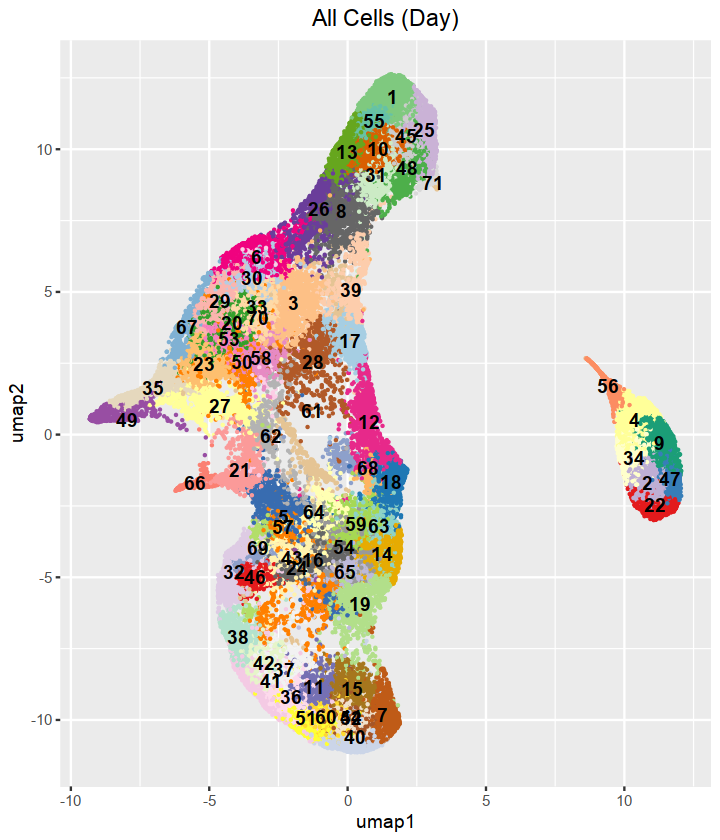

In [16]:
options(repr.plot.width = 6, repr.plot.height = 7)

df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                clst=as.factor(clusters))
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.2, alpha=1, aes(x=umap1 , y=umap2, col=clst)) +
# scale_color_brewer( palette = "Set1") +
scale_color_manual(values=col_vector) +
geom_text(data=data.frame(aggregate(metaData[,c("umap1","umap2")], 
                                    list(clusters), mean)),
         aes(x=umap1, y=umap2, label=Group.1), fontface = "bold") +
ggtitle("All Cells (Day)") + 
theme(plot.title = element_text(hjust = 0.5),
      legend.positio = "none")
# guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4))) 

In [17]:
# find ~pseudotime for cluster (average of days of cells in it)
# this is used to order peak sets later
# may be more accurate if done with pseudotime

# average of days
samp_to_time = seq(length(DAYS))
names(samp_to_time) = DAYS

cluster_to_pseudotime_avg = aggregate(samp_to_time[as.character(metaData$sample)], list(clusters), mean)

rownames(cluster_to_pseudotime_avg) = paste("cluster", cluster_to_pseudotime_avg$Group.1, sep="_")
cluster_to_pseudotime_avg$Group.1 = NULL
colnames(cluster_to_pseudotime_avg) = c("day_avg")
head(cluster_to_pseudotime_avg)

day_avg 
cluster_1 7.956665
cluster_2 9.000000
cluster_3 4.595840
cluster_4 9.000000
cluster_5 2.660156
cluster_6 4.736973

In [18]:
cluster_to_pseudotime_avg[1,]
cluster_to_pseudotime_avg[6,]

[1] 7.956665

[1] 4.736973

## Make pseudo-bulk matrix

In [19]:
agg_matrix = sparseMatrix(i=clusters,
                         j=seq(1,nrow(pmat)),
                         x=1L,
                         dims=c(length(table(clusters)), nrow(pmat)))

In [20]:
cts = as.matrix(agg_matrix %*% pmat)
colnames(cts) = sub("_", "-", sub("_", ":", rownames(regions)))
rownames(cts) = paste("cluster", seq(1,nrow(cts)), sep="_")
cts = t(cts)
head(cts)
dim(cts)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr17:32960817-32961317  1         12        7          7        6       
chr17:75764252-75764752 10        125       34        130       20       
chr17:1473114-1473614    6         48       30         29       19       
chr17:4206897-4207397    0          5        3          6        4       
chr17:423409-423909      0          9        8          8        2       
chr17:1964634-1965134    1          6        1          0        2       
                        cluster_6 cluster_7 cluster_8 cluster_9 cluster_10 ⋯
chr17:32960817-32961317  4         2         2         11        0         ⋯
chr17:75764252-75764752 44        67        16        149       14         ⋯
chr17:1473114-1473614   28         9         5         57        7         ⋯
chr17:4206897-4207397    2         5         1          4        0         ⋯
chr17:423409-423909      7         2         6         15        5         ⋯
chr17:1964634-1965134    0         1         1          4        1         ⋯
                        cluster_62 cluster_63 cluster_64 cluster_65 cluster_66
chr17:32960817-32961317  6          6          7          5          1        
chr17:75764252-75764752 15         24         22         23          4        
chr17:1473114-1473614    6          2          6          3         23        
chr17:4206897-4207397    1          3          2          5          2        
chr17:423409-423909      4          6          5          3          0        
chr17:1964634-1965134    0          0          0          1         11        
                        cluster_67 cluster_68 cluster_69 cluster_70 cluster_71
chr17:32960817-32961317 0          1          1          1          2         
chr17:75764252-75764752 6          8          2          4          3         
chr17:1473114-1473614   9          1          2          2          0         
chr17:4206897-4207397   1          0          2          0          0         
chr17:423409-423909     0          0          0          1          0         
chr17:1964634-1965134   0          0          0          0          0

[1] 530910     71

In [21]:
# removing smallest cluster since it has few cells and seem to be degenerate
# cts = cts[, 1:26]
# head(cts,2)

In [22]:
quantile(rowSums(cts), c(0, 0.02, 0.05,  0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1))

0%       2%       5%      10%      25%      50%      75%      90% 
   25.00   100.00   129.00   164.00   250.00   441.00  1001.00  2484.00 
     99%     100% 
12006.91 40619.00

In [23]:
sample(rownames(cts)[rowSums(cts)<quantile(rowSums(cts), 0.02)], 10)

[1] "chr5:56748276-56748776"    "chr13:105507513-105508013"
 [3] "chr14:63365070-63365570"   "chr7:48157227-48157727"   
 [5] "chr3:33604924-33605424"    "chr3:59146132-59146632"   
 [7] "chr2:214756855-214757355"  "chr13:65728084-65728584"  
 [9] "chr2:240314582-240315082"  "chr3:106931487-106931987"

In [24]:
# cts = cts[rowSums(cts)>quantile(rowSums(cts), 0.05), ]
# dim(cts)

In [25]:
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [26]:
log_norm_cts = log2(1+norm_cts)

In [27]:
# cts_to_cluster = log_norm_cts 

# scale counts by width of bin
cts_to_cluster = log2(1+501*(norm_cts/width(GRanges(rownames(norm_cts)))))

# z norm
# cts_to_cluster = t(scale(t(cts_to_cluster)))

# append z norm
znormed = t(scale(t(cts_to_cluster)))
colnames(znormed) = paste(colnames(znormed), "znorm", sep='_')
cts_to_cluster = cbind(cts_to_cluster, znormed)

### Split by Fibroblast and iPSC states

These should be lists (BED files) that are subsets of peak set that are open in fibroblast and iPSCs.

E.g. below are peaks based on coverage of peak set with fibr/iPSC peaks (extended 250bp on either side of summit), such that at least 50% of peak overlaps with fibr/iPSC extended peaks.

In [35]:
fibr_open = read.table("../20200122_snapATAC/snapATAC_sessions/20210714_n64913/peaks/fibr_iPSC_states/overlap.peaks.resolved.500.fibr.bed", sep='\t')
fibr_open = paste(paste(fibr_open$V1, fibr_open$V2, sep=':'), fibr_open$V3, sep='-')

In [37]:
ipsc_open = read.table("../20200122_snapATAC/snapATAC_sessions/20210714_n64913/peaks/fibr_iPSC_states/overlap.peaks.resolved.500.ipsc.bed", sep='\t')
ipsc_open = paste(paste(ipsc_open$V1, ipsc_open$V2, sep=':'), ipsc_open$V3, sep='-')

In [38]:
sum(rownames(cts_to_cluster) %in% fibr_open)

[1] 192465

In [39]:
sum(rownames(cts_to_cluster) %in% ipsc_open)

[1] 189860

In [41]:
nrow(cts_to_cluster)

[1] 530910

In [42]:
# all 4 states
states = (rownames(cts_to_cluster) %in% fibr_open) + 2*(rownames(cts_to_cluster) %in% ipsc_open)
table(states)

states
     0      1      2      3 
229458 111592 108987  80873 

### Cluster

In [44]:
km_mb_open_open = MiniBatchKmeans(cts_to_cluster[states==3, ], 
                        batch_size = 1000,
                        clusters = 3,
                        num_init = 50, 
                        verbose = FALSE)

In [45]:
km_mb_open_close = MiniBatchKmeans(cts_to_cluster[states==1, ], 
                        batch_size = 1000,
                        clusters = 3,
                        num_init = 50, 
                        verbose = FALSE)

In [47]:
km_mb_close_open = MiniBatchKmeans(cts_to_cluster[states==2, ], 
                        batch_size = 1000,
                        clusters = 4,
                        num_init = 50, 
                        verbose = FALSE)

In [135]:
km_mb_close_close = MiniBatchKmeans(cts_to_cluster[states==0, ], 
                        batch_size = 1000,
                        clusters = 14,
                        num_init = 50, 
                        verbose = FALSE)

### Routine to cluster centroids and reorder 

In [136]:
km_mb_centroids = rbind(km_mb_open_close$centroids, 
                        km_mb_close_close$centroids, 
                        km_mb_close_open$centroids, 
                        km_mb_open_open$centroids)

km_mb_centroids_noznorm = km_mb_centroids[, 1:length(unique(clusters))]

In [137]:
# rough average pseudotime per cluster: accs weighted average of pseudotimes of each cluster
# will use this for ordering clusters after dendrogram (within each category [close-open, open-close, transient, low variabce])
cluster_avg_pseudotime = cluster_to_pseudotime_avg[colnames(cts_to_cluster)[1:length(unique(clusters))], "day_avg"]
centroid_pseudotimes = -rowSums(t(t(km_mb_centroids_noznorm)*cluster_avg_pseudotime))/rowSums(km_mb_centroids_noznorm)

In [138]:
reorder_index_set <- function(centroids, idxs, pseudotimes) {
    stopifnot(all(sort(idxs)==idxs))
    stopifnot(nrow(centroids)==length(pseudotimes)) # should not be indexed yet
    
    distance    = dist(centroids[idxs, ])
    cluster = hclust(distance, method="complete")
    dendrogram = as.dendrogram(cluster)
    
    # reorder based on average pseudotime of peak sets
    dendrogram = reorder(dendrogram, pseudotimes[idxs], mean)
    
    # old: new_to_old_map[i] -> new: i [but old go from 1..length(idxs), convert to actual idxs]
    new_to_old_map = rev(order.dendrogram(dendrogram))

    # replace with actual indxs (this works since idxs is sorted)
    new_to_old_map[order(new_to_old_map)] = idxs
    
    new_to_old_map
}

In [139]:
# km_mb$centroids will include the znormed parts
i = 1
new_to_old_open_close = reorder_index_set(km_mb_centroids, seq(nrow(km_mb_open_close$centroids)), centroid_pseudotimes)
i = i + nrow(km_mb_open_close$centroids)
            
new_to_old_transient = reorder_index_set(km_mb_centroids, i:(i+nrow(km_mb_close_close$centroids)-1), centroid_pseudotimes)
i = i + nrow(km_mb_close_close$centroids)

new_to_old_close_open = reorder_index_set(km_mb_centroids, i:(i+nrow(km_mb_close_open$centroids)-1), centroid_pseudotimes)
i = i + nrow(km_mb_close_open$centroids)

new_to_old_low_disp = reorder_index_set(km_mb_centroids, i:(i+nrow(km_mb_open_open$centroids)-1), centroid_pseudotimes)

In [140]:
# options(repr.plot.width = 10, repr.plot.height = 7)
# ggdendrogram(dendrogram)

In [141]:
length(new_to_old_open_close)
length(new_to_old_transient)
length(new_to_old_close_open)
length(new_to_old_low_disp)

[1] 3

[1] 14

[1] 4

[1] 3

In [142]:
new_to_old_complete = c(new_to_old_open_close,
                       new_to_old_transient,
                       new_to_old_close_open,
                       new_to_old_low_disp)

In [143]:
# cluster assignments per peak
pr_mb = rep(0, nrow(cts_to_cluster))

i = 0
pr_mb_open_close = predict_MBatchKMeans(cts_to_cluster[states==1,], km_mb_open_close$centroids)
pr_mb[states==1] = pr_mb_open_close
i = i + nrow(km_mb_open_close$centroids)

pr_mb_close_close = predict_MBatchKMeans(cts_to_cluster[states==0,], km_mb_close_close$centroids)
pr_mb[states==0] = pr_mb_close_close + i
i = i + nrow(km_mb_close_close$centroids)

pr_mb_close_open = predict_MBatchKMeans(cts_to_cluster[states==2,], km_mb_close_open$centroids)
pr_mb[states==2] = pr_mb_close_open + i
i = i + nrow(km_mb_close_open$centroids)

pr_mb_open_open = predict_MBatchKMeans(cts_to_cluster[states==3,], km_mb_open_open$centroids)
pr_mb[states==3] = pr_mb_open_open + i

In [144]:
sum(pr_mb==0) == 0

[1] TRUE

In [145]:
sort(table(pr_mb))

pr_mb
    4     6    12    14     7    13    19    16    11    10     5    23    17 
 5075  6907  9594 11145 11645 13119 15179 16396 17471 18794 18844 19750 21090 
    1    15    20     8    22     9    21    24    18     2     3 
21137 23500 23696 25664 28260 30214 32573 32863 37539 39006 51449 

In [146]:
# reorder to new indices
pr_mb = order(new_to_old_complete)[pr_mb]

### If no reordering

In [147]:
# no hierarchical clustering, follow order of km_mb$centroids
# pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)

---

In [148]:
sort(table(pr_mb))

pr_mb
    4     5    13    11     6    15    18    12    16    14    10    22    17 
 5075  6907  9594 11145 11645 13119 15179 16396 17471 18794 18844 19750 21090 
    3     9    20     7    24     8    19    23    21     1     2 
21137 23500 23696 25664 28260 30214 32573 32863 37539 39006 51449 

In [149]:
cts_clustered = cts_to_cluster[order(pr_mb), 1:length(unique(clusters))] # divide when znormed pasted
head(cts_clustered, 2)

cluster_1 cluster_2 cluster_3 cluster_4 cluster_5
chr17:8056095-8056595   0.000000  1.305869  1.949526  2.315875  4.193331 
chr17:35115886-35116386 2.261808  2.054843  2.643365  1.908712  3.344241 
                        cluster_6 cluster_7 cluster_8 cluster_9 cluster_10 ⋯
chr17:8056095-8056595   2.550238  3.720444  0         2.261968  1.159022   ⋯
chr17:35115886-35116386 1.297011  3.779808  0         1.596828  2.232408   ⋯
                        cluster_62 cluster_63 cluster_64 cluster_65 cluster_66
chr17:8056095-8056595   3.602311   4.408326   4.093030   5.191829   1.857194  
chr17:35115886-35116386 3.987342   3.715958   4.186919   4.386012   0.000000  
                        cluster_67 cluster_68 cluster_69 cluster_70 cluster_71
chr17:8056095-8056595   2.471398   5.040763   4.686869   1.987997   3.78941   
chr17:35115886-35116386 3.100364   0.000000   3.741821   1.987997   0.00000

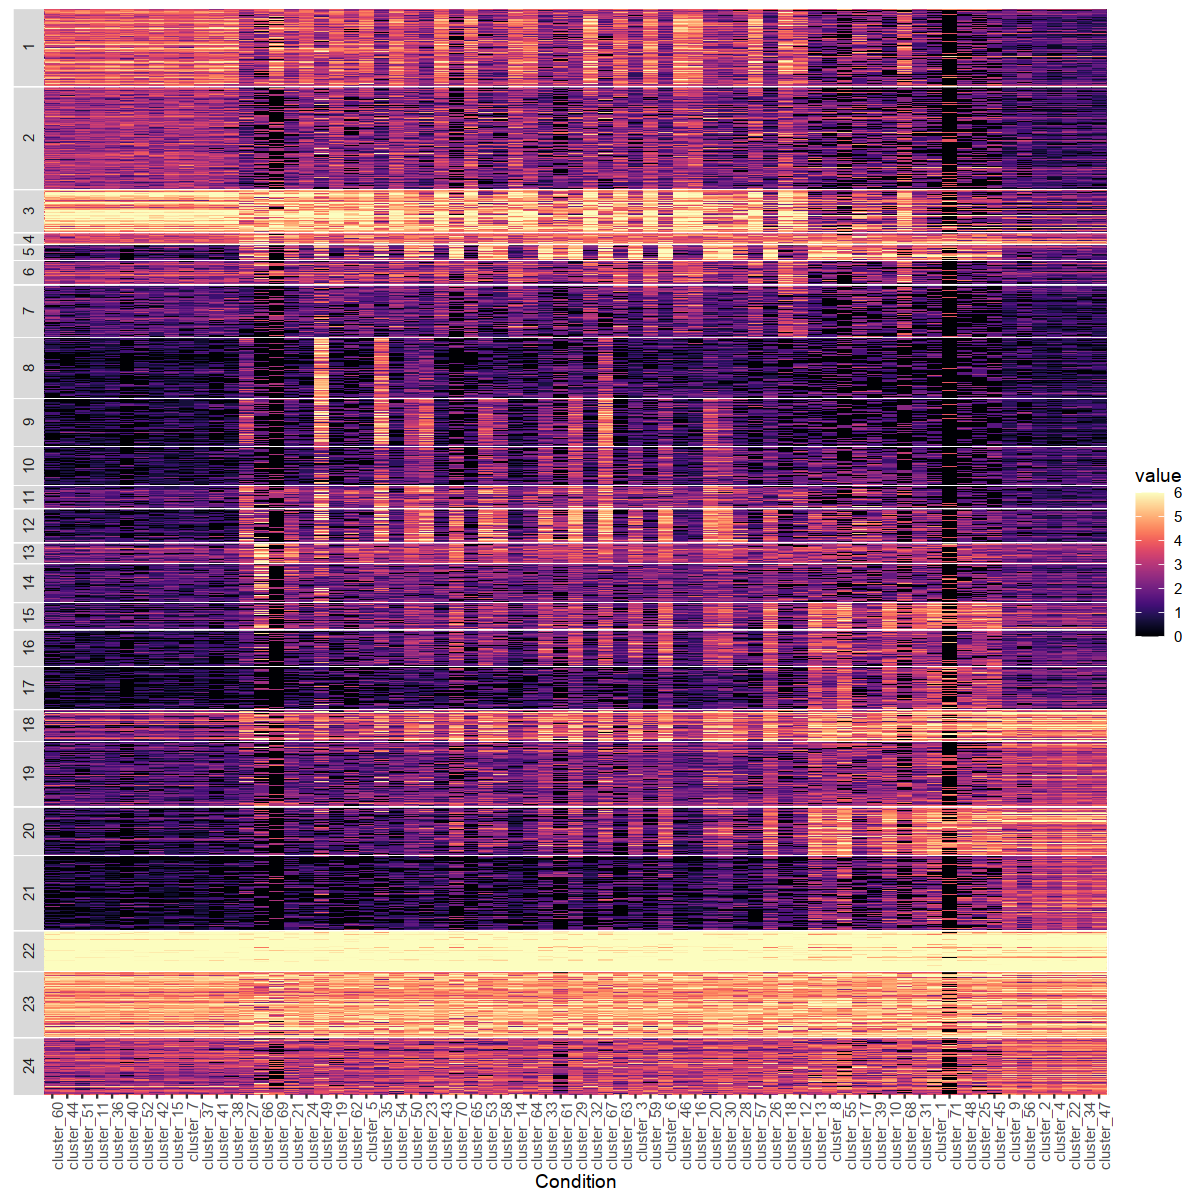

In [150]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered), 100) # if subsample
ggplot(data = melt(cts_clustered[idxs, ]), 
       mapping = aes(x = factor(Var2, 
                                levels=paste(rownames(cluster_to_pseudotime_avg)[order(cluster_to_pseudotime_avg$day_avg)])),
                     y = Var1,
                     fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(0, 6), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank(),
      panel.spacing.y = unit(0.04, "cm"))
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

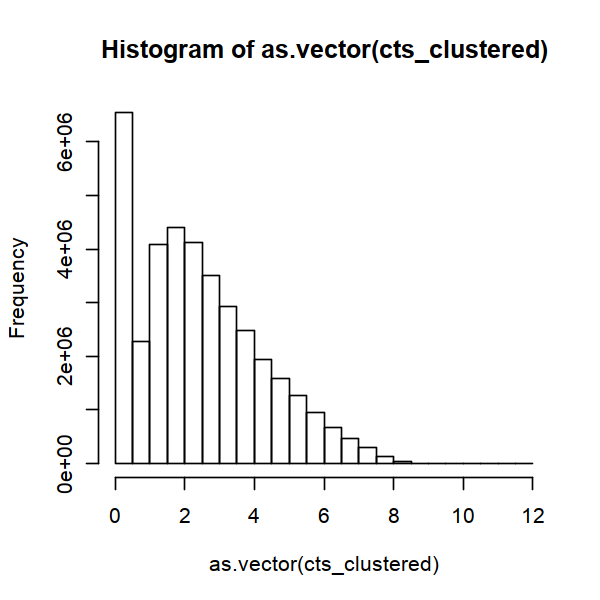

In [151]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(as.vector(cts_clustered))

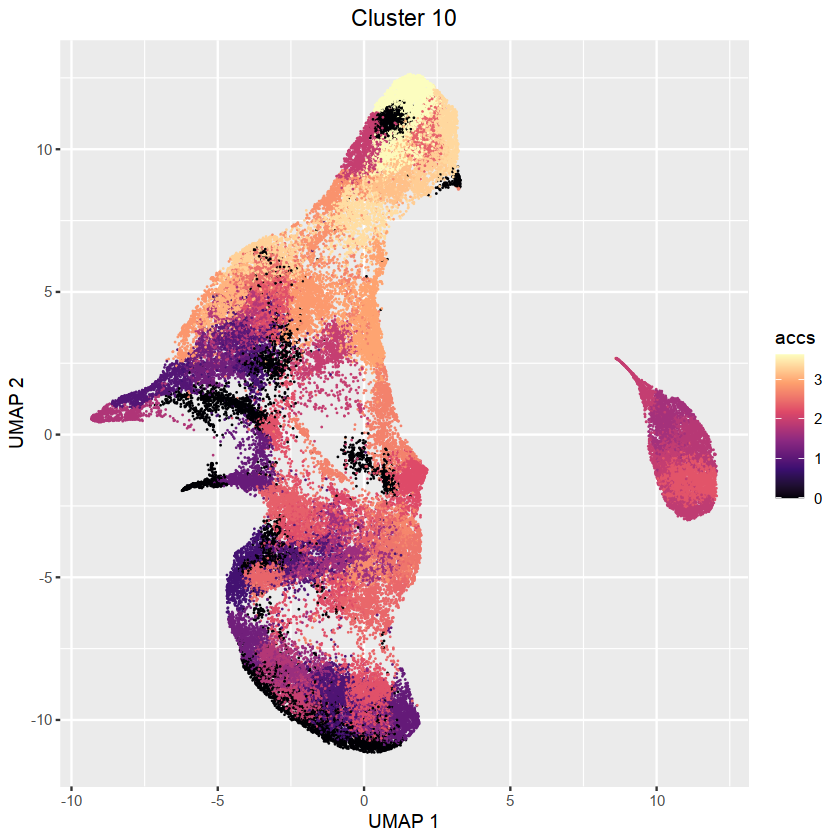

In [149]:
options(repr.plot.width = 7, repr.plot.height = 7)
selected_cluster_id = 10

# visualize a centroid
# df = data.frame(x.sp@umap, accs=km_mb$centroids[selected_cluster_id, ][clusters])

# or a specific peak
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2, 
                accs=log2(1+norm_cts["chr11:64510709-64511209", ][clusters]))

# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke = 0,alpha=1, aes(x=umap1 , y=umap2, col=accs)) +
ggtitle(sprintf("Cluster %d", selected_cluster_id)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(#limits=c(0, 6),
                      oob=squish, option = "A") +
theme(plot.title = element_text(hjust = 0.5))

In [152]:
plots = list()
for (i in seq(1,length(table(pr_mb)))) {
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2, 
                    centroid_accs=km_mb_centroids[new_to_old_complete[i], ][clusters])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    plots[[i]] <- ggplot(df) +
    # ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
    geom_point(size=0.8, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=centroid_accs)) +
    ggtitle(sprintf("Cluster %d", i)) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=c(0,6), oob=squish, option = "A") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
}

In [153]:
# get legend
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                centroid_accs=km_mb_centroids[1, ][clusters])
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 20000), ]

cur_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=1, alpha=1, aes(x=umap1 , y=umap2, col=centroid_accs)) +
ggtitle(sprintf("Cluster %d", i)) + 
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, 6), oob=squish, option = "A") +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
     axis.ticks = element_blank(),
     axis.text =element_blank(),
     axis.line=element_blank(),
     panel.border = element_rect(colour = "black", fill=NA, size=0.5))

legend_only = cowplot::get_legend(cur_plot)

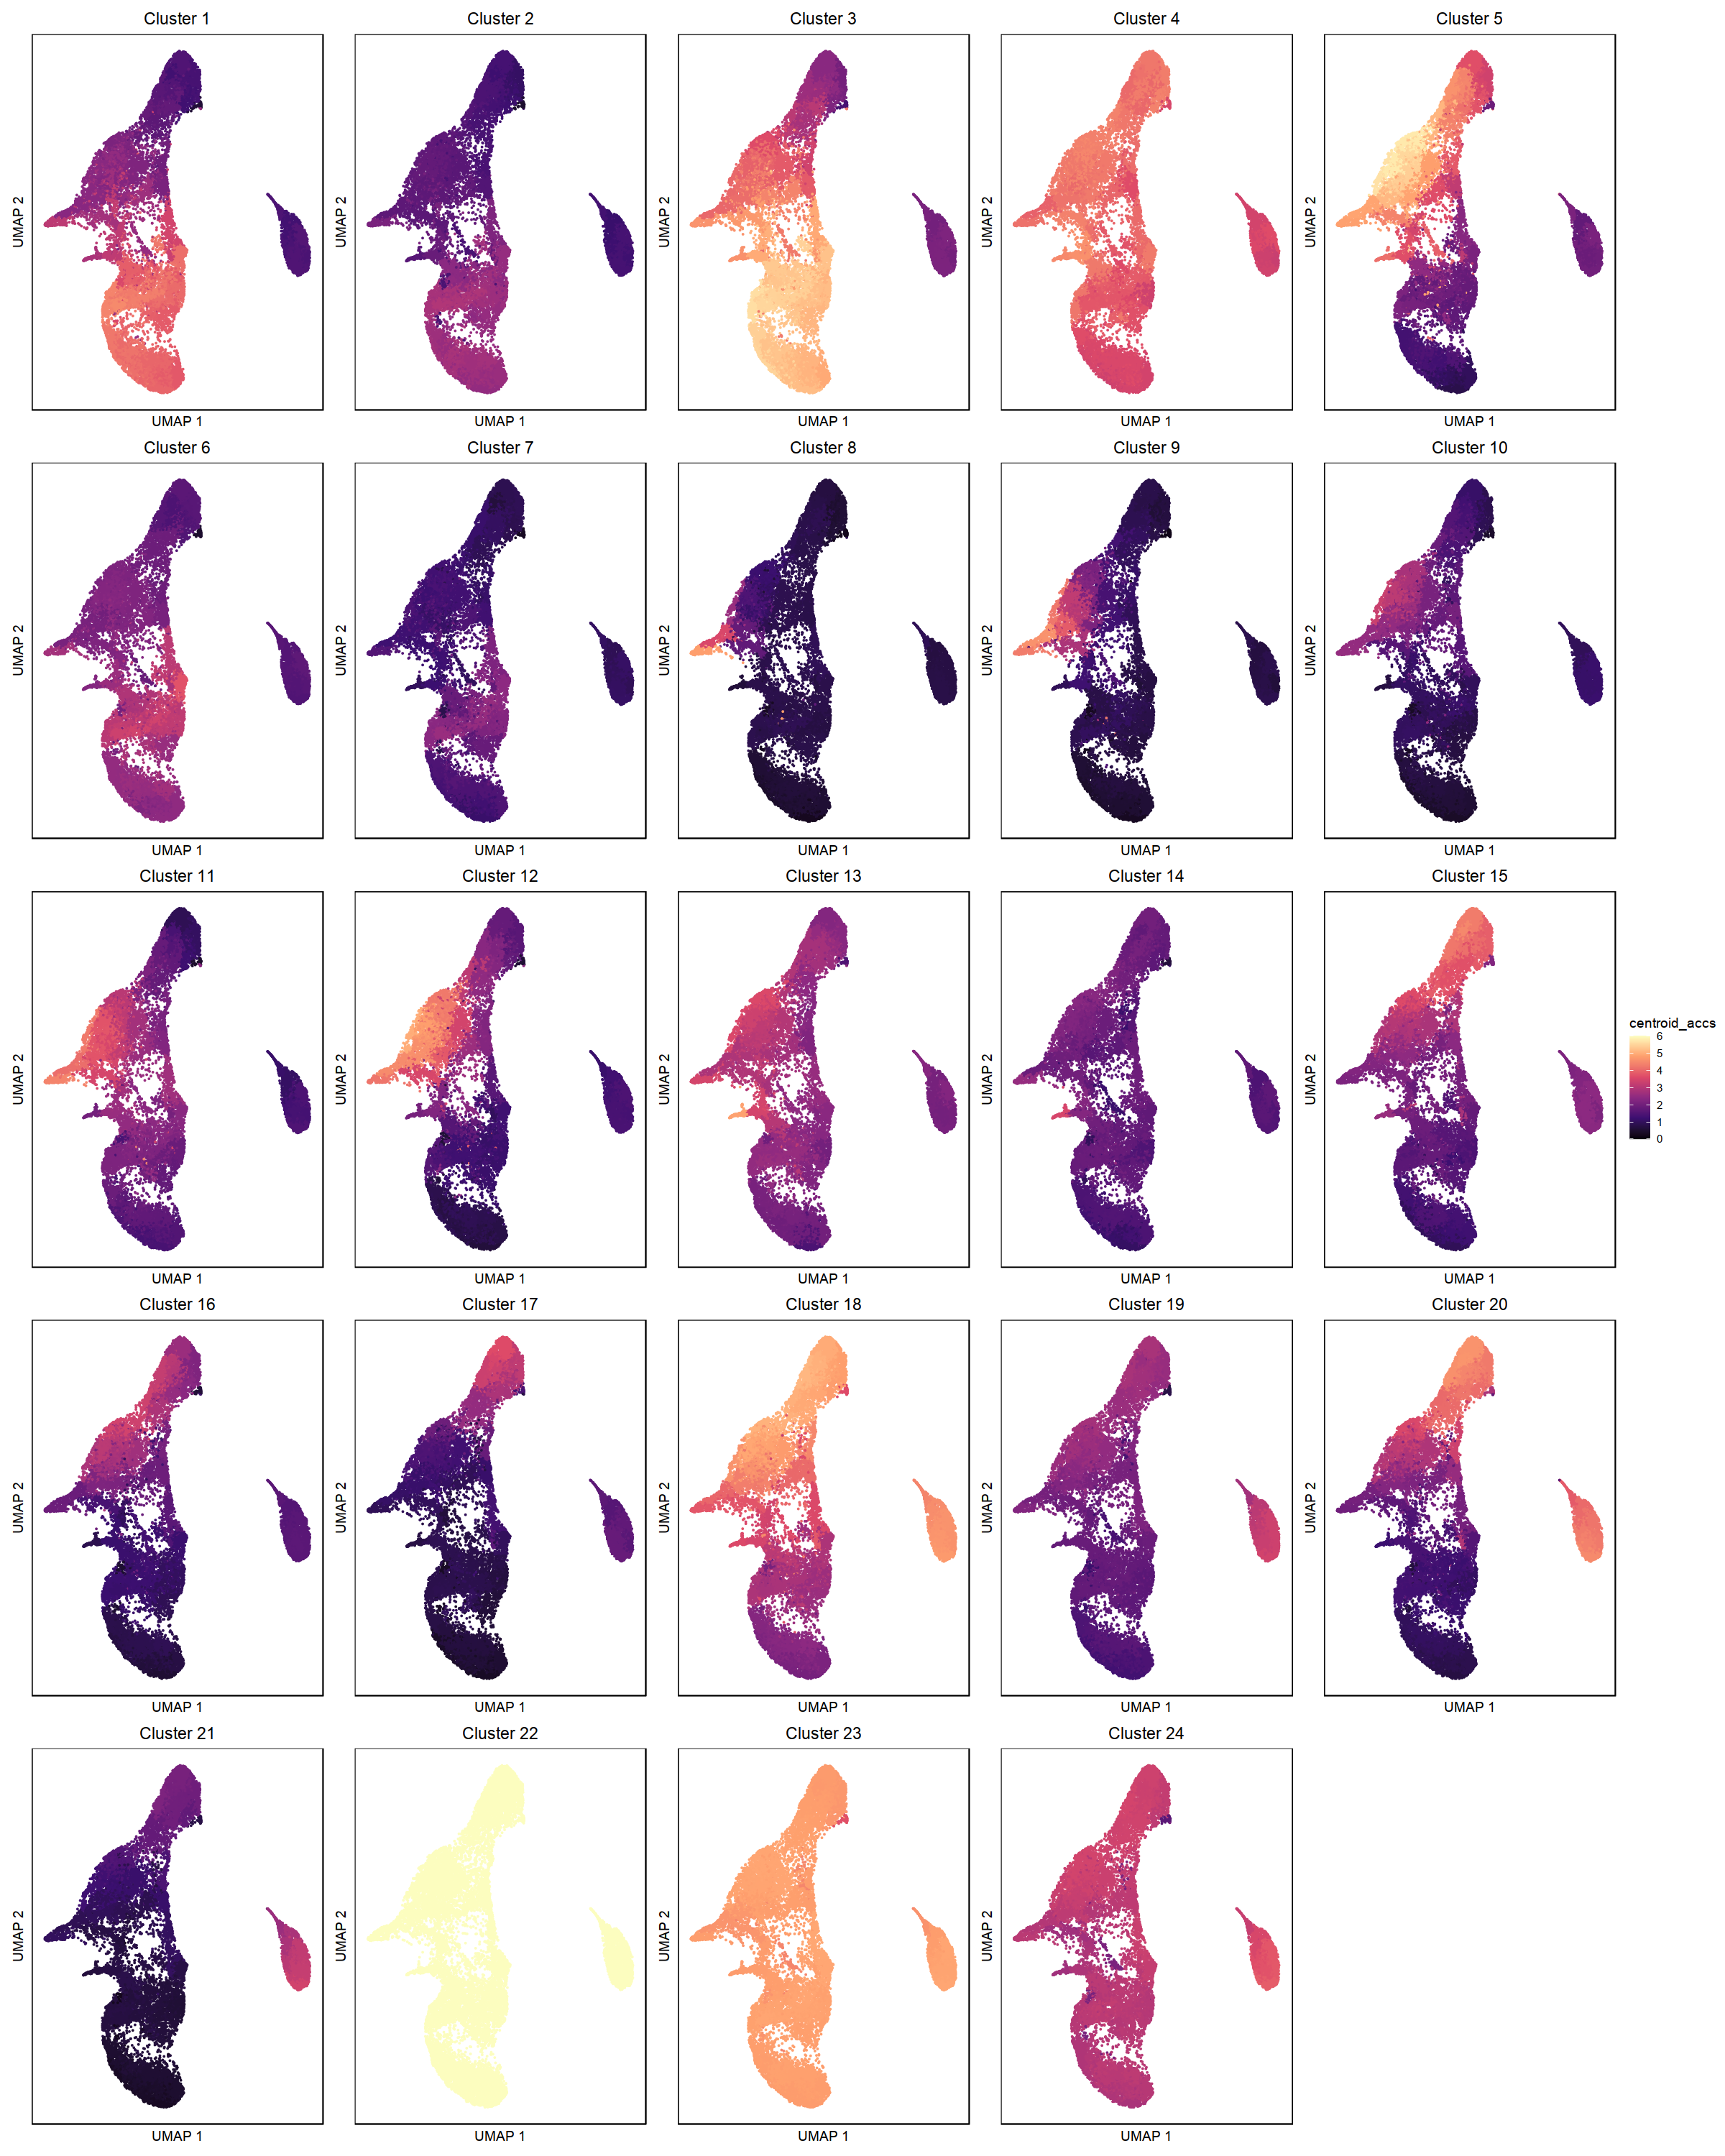

In [154]:
options(repr.plot.width = 20, repr.plot.height = 25)
wrap_plots(wrap_plots(plots, ncol = 5), legend_only, widths=c(0.95,0.05))  
# ggsave(sprintf("figs/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/log_cts.jpeg"),
# #                format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=20, height=40, dpi=300)

## Writing BED files for Peak Sets

In [155]:
CLUSTER_IDX = 1
NORM = 'gridmap_peakwidthnorm_logplusznorm_4way_assited'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n24/idx1.bed"

In [156]:
km_mb_close_close = MiniBatchKmeans(cts_to_cluster[states==0, ], 
                        batch_size = 1000,
                        clusters = 10,
                        num_init = 50, 
                        verbose = FALSE)

In [157]:
peak_formatted = sub('-', '\t', sub(':', '\t', rownames(cts_to_cluster)))

In [158]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(peak_formatted[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [159]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(peak_formatted, fileConn)
close(fileConn)

[1] "beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n24/all_peaks.bed"


## Fraction in Peak Plots

For each peak set, plot graphs similar to above but instead with fraction of reads in peak set for each single cell.

In [131]:
pmatRowSums = Matrix::rowSums(pmat)

In [132]:
peaks_gr = makeGRangesFromDataFrame(data.frame(chr=regions$chr,
                                   start=regions$bp1,
                                   end=regions$bp2))

In [173]:
plots = list()
for (i in seq(1,20)) {
    fname = sprintf("./beds/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx%d.bed", i)
    region_gr = read.table(fname)

    colnames(region_gr) = c("chr", "start", "end")
    region_gr = makeGRangesFromDataFrame(region_gr)
    
    norm_reads_in_region = Matrix::rowSums(pmat[, unique(queryHits(findOverlaps(peaks_gr, region_gr)))])/pmatRowSums
    
    df = data.frame(umap1=metaData$umap1, 
                    umap2=metaData$umap2,
                    percent_reads=100*norm_reads_in_region)
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 30000), ]

    plots[[i]] = ggplot(df) +
    # ggplot(df[df$percent_reads<2, ]) +
    geom_point(size=0.5, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=percent_reads)) +
    ggtitle(sprintf("Peak Set %d \n (%d peaks)",  
                   i, length(region_gr))) + 
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits= c(0, 
                                  quantile(100*norm_reads_in_region, 0.99)), 
                          oob=squish, option = "B") +
    theme_classic() +
    theme(plot.title = element_text(hjust = 0.5),
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         panel.border = element_rect(colour = "black", fill=NA, size=0.5))
}

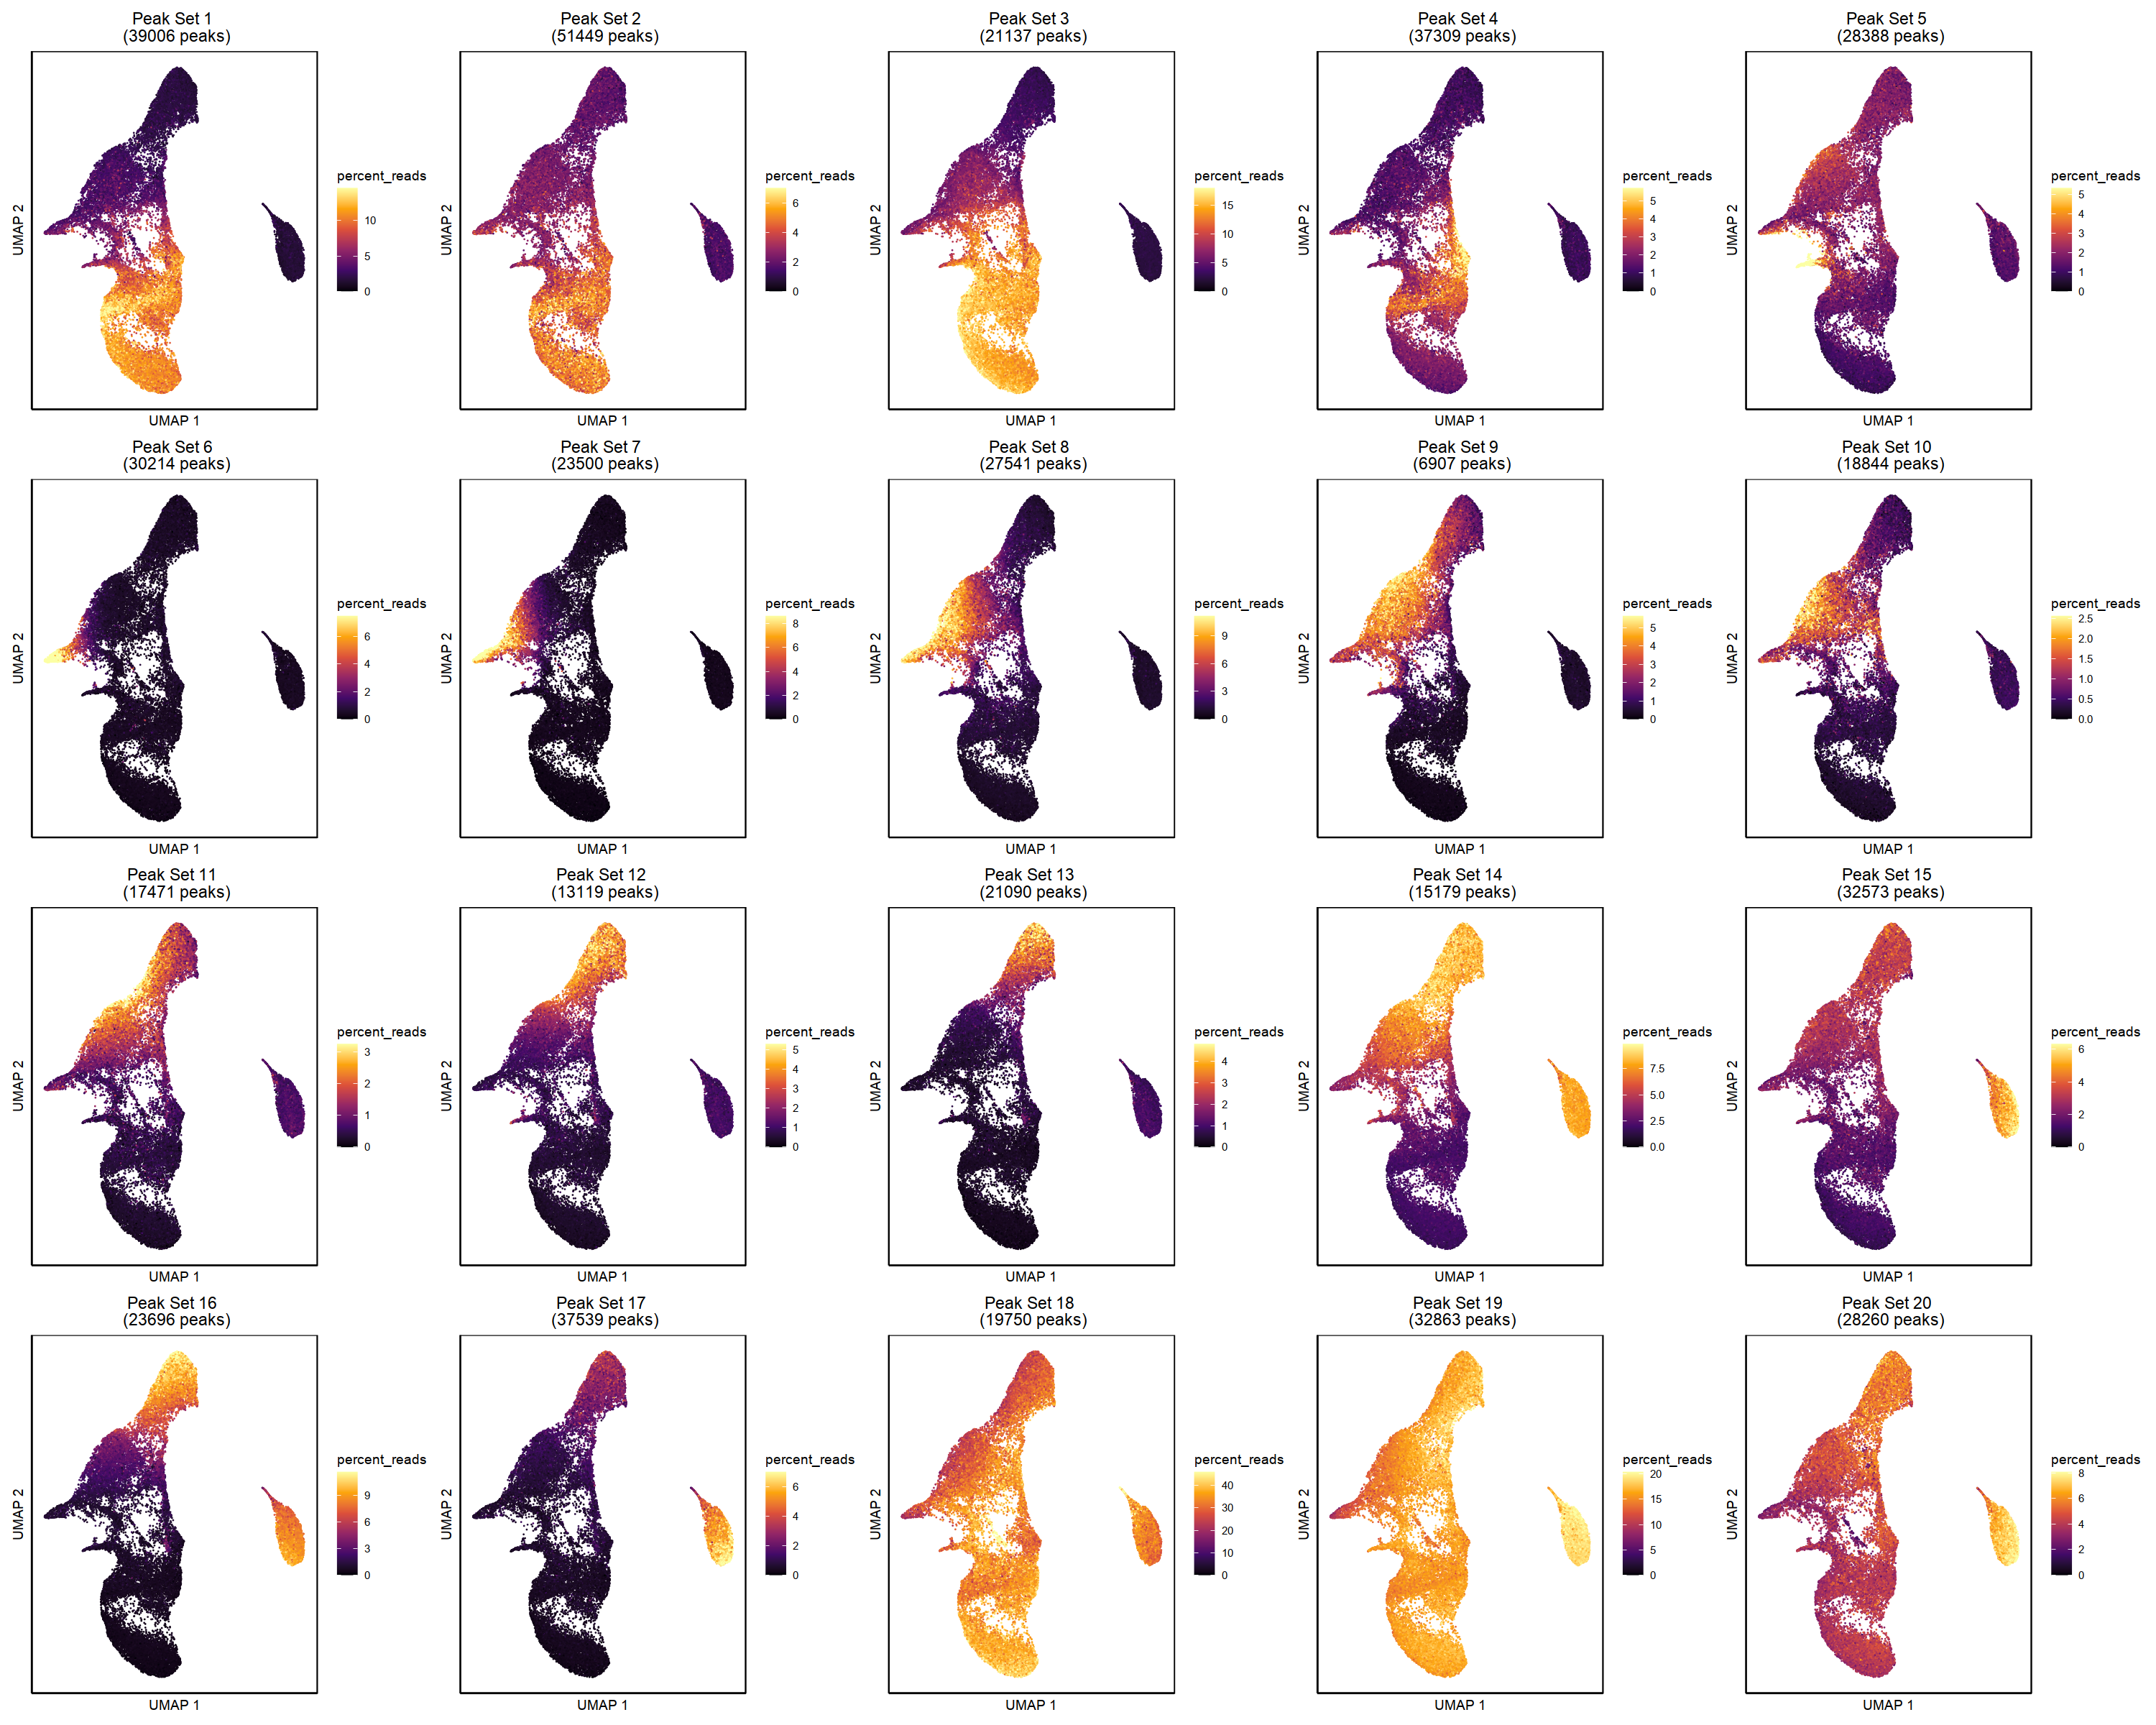

In [166]:
options(repr.plot.width = 25, repr.plot.height = 20)
wrap_plots(plots, ncol = 5) 
# ggsave(sprintf("figs/%s_gridmap_peakwidthnorm_sc_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        width=30, height=35, dpi=300)

In [99]:
# options(repr.plot.width = 25, repr.plot.height = 5)
# wrap_plots(list(plots[[5]], plots[[11]], plots[[20]], plots[[18]], plots[[19]]), ncol = 5)

In [100]:
# options(repr.plot.width = 25, repr.plot.height = 5)
# wrap_plots(list(plots[[13]], plots[[14]], plots[[17]], plots[[10]], plots[[16]]), ncol = 5)

In [101]:
# options(repr.plot.width = 15, repr.plot.height = 10)
# wrap_plots(list(plots[[2]], plots[[12]], plots[[9]], plots[[7]], plots[[1]], plots[[15]]), ncol = 3)

---

In [162]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] leiden_0.3.3                RANN_2.6.1                 
 [3] ggdendro_0.1-20             Matrix_1.2-18              
 [5] cowplot_1.0.0               patchwork_1.0.0            
 [7] RColorBrewer_1.1-2          ClusterR_1.2.2             
 [9] gtools_3.8.2              